In [3]:
%matplotlib inline

import pandas as pd
import numpy as np


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

from sklearn import metrics


2023-01-23 01:29:05.703240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 01:29:08.219919: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-23 01:29:08.220056: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-23 01:29:12.376279: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Load input data

In [4]:
#Hardcoded values
timestep = 16 # 2 seconds
epoch = 200

In [5]:
path = 'MovementAAL/dataset/MovementAAL_RSS_'

sequences = list()
file_targets = pd.read_csv('MovementAAL/dataset/MovementAAL_target.csv')

targets = list()

for i in range(1,315):
    file_path = path + str(i) + '.csv'
    file = pd.read_csv(file_path, header=0)
    for j in range(0, (len(file) - timestep)+1):
        arr = file[j:j+timestep]
        sequences.append(arr)
        targets.append(file_targets.values[:,1][i-1])


In [6]:
print(len(sequences))
print(len(targets))
sequences[0]

8487
8487


,RSS_anchor1,RSS_anchor2,RSS_anchor3,RSS_anchor4
0,-0.904760,-0.48,0.285710,0.30
1,-0.571430,-0.32,0.142860,0.30
2,-0.380950,-0.28,-0.142860,0.35
3,-0.285710,-0.20,-0.476190,0.35
4,-0.142860,-0.20,0.142860,-0.20
5,-0.142860,-0.20,0.047619,0.00
6,-0.142860,-0.16,-0.380950,0.20
7,-0.142860,-0.04,-0.619050,-0.20
8,-0.095238,-0.08,0.142860,-0.55
9,-0.047619,0.04,-0.095238,0.05


In [7]:
groups = pd.read_csv('MovementAAL/groups/MovementAAL_DatasetGroup.csv', header=0)
groups = groups.values[:,1]

In [8]:
len_sequences = []
for one_seq in sequences:
    len_sequences.append(len(one_seq))
pd.Series(len_sequences).describe()


count    8487.0
mean       16.0
std         0.0
min        16.0
25%        16.0
50%        16.0
75%        16.0
max        16.0
dtype: float64

In [9]:
X_train, X_rest, Y_train, Y_rest = train_test_split(sequences, targets, test_size=0.5, random_state=0)
X_test, X_validation, Y_test, Y_validation  = train_test_split(X_rest, Y_rest, test_size=0.4, random_state=0)

print(len(X_train))
print(len(X_validation))
print(len(X_test))
print(len(X_train)+len(X_validation)+len(X_test))
print(len(sequences))

4243
1698
2546
8487
8487


In [10]:
X_train = np.array(X_train)
X_validation = np.array(X_validation)
X_test = np.array(X_test)

Y_train = np.array(Y_train)
Y_train = (Y_train+1)/2

Y_validation = np.array(Y_validation)
Y_validation = (Y_validation+1)/2

Y_test = np.array(Y_test)
Y_test = (Y_test+1)/2


In [11]:
model = Sequential()
model.add(LSTM(256, input_shape=(timestep, 4),dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

2023-01-23 01:29:26.804889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 01:29:26.811179: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-23 01:29:26.811849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-23 01:29:26.812227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-23 01:29:26.812600: W tensorf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               267264    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________


In [12]:
adam = Adam(learning_rate=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=epoch, batch_size=256, callbacks=[chk], validation_data=(X_validation,Y_validation))

Epoch 1/200
17/17 [==============================] - ETA: 0s - loss: 0.6404 - accuracy: 0.6510
Epoch 1: val_accuracy improved from -inf to 0.69965, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 27s 1s/step - loss: 0.6404 - accuracy: 0.6510 - val_loss: 0.5934 - val_accuracy: 0.6996
Epoch 2/200
17/17 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.7040
Epoch 2: val_accuracy improved from 0.69965 to 0.73498, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 23s 1s/step - loss: 0.5765 - accuracy: 0.7040 - val_loss: 0.5401 - val_accuracy: 0.7350
Epoch 3/200
17/17 [==============================] - ETA: 0s - loss: 0.5327 - accuracy: 0.7429
Epoch 3: val_accuracy improved from 0.73498 to 0.74558, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 15s 927ms/step - loss: 0.5327 - accuracy: 0.7429 - val_loss: 0.5046 - val_accuracy: 0.7456
Epoch 4/200
17/17 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.7693
Epoch 4: val_accuracy improved from 0.74558 to 0.79034, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 12s 728ms/step - loss: 0.4836 - accuracy: 0.7693 - val_loss: 0.4413 - val_accuracy: 0.7903
Epoch 5/200
17/17 [==============================] - ETA: 0s - loss: 0.4356 - accuracy: 0.7933
Epoch 5: val_accuracy did not improve from 0.79034
17/17 [==============================] - 3s 197ms/step - loss: 0.4356 - accuracy: 0.7933 - val_loss: 0.4479 - val_accuracy: 0.7792
Epoch 6/200
17/17 [==============================] - ETA: 0s - loss: 0.4224 - accuracy: 0.7959
Epoch 6: val_accuracy improved from 0.79034 to 0.81861, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 16s 1s/step - loss: 0.4224 - accuracy: 0.7959 - val_loss: 0.4012 - val_accuracy: 0.8186
Epoch 7/200
17/17 [==============================] - ETA: 0s - loss: 0.3939 - accuracy: 0.8117
Epoch 7: val_accuracy improved from 0.81861 to 0.81920, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 560ms/step - loss: 0.3939 - accuracy: 0.8117 - val_loss: 0.3824 - val_accuracy: 0.8192
Epoch 8/200
17/17 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.8155
Epoch 8: val_accuracy did not improve from 0.81920
17/17 [==============================] - 3s 173ms/step - loss: 0.3867 - accuracy: 0.8155 - val_loss: 0.3885 - val_accuracy: 0.8033
Epoch 9/200
17/17 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.8249
Epoch 9: val_accuracy improved from 0.81920 to 0.82097, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 570ms/step - loss: 0.3684 - accuracy: 0.8249 - val_loss: 0.3555 - val_accuracy: 0.8210
Epoch 10/200
17/17 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.8310
Epoch 10: val_accuracy improved from 0.82097 to 0.83098, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 536ms/step - loss: 0.3636 - accuracy: 0.8310 - val_loss: 0.3484 - val_accuracy: 0.8310
Epoch 11/200
17/17 [==============================] - ETA: 0s - loss: 0.3637 - accuracy: 0.8282
Epoch 11: val_accuracy did not improve from 0.83098
17/17 [==============================] - 3s 175ms/step - loss: 0.3637 - accuracy: 0.8282 - val_loss: 0.3649 - val_accuracy: 0.8198
Epoch 12/200
17/17 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.8376
Epoch 12: val_accuracy improved from 0.83098 to 0.84982, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 561ms/step - loss: 0.3524 - accuracy: 0.8376 - val_loss: 0.3268 - val_accuracy: 0.8498
Epoch 13/200
17/17 [==============================] - ETA: 0s - loss: 0.3453 - accuracy: 0.8388
Epoch 13: val_accuracy did not improve from 0.84982
17/17 [==============================] - 3s 172ms/step - loss: 0.3453 - accuracy: 0.8388 - val_loss: 0.3332 - val_accuracy: 0.8398
Epoch 14/200
17/17 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.8348
Epoch 14: val_accuracy improved from 0.84982 to 0.86337, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 537ms/step - loss: 0.3456 - accuracy: 0.8348 - val_loss: 0.3133 - val_accuracy: 0.8634
Epoch 15/200
17/17 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.8419
Epoch 15: val_accuracy improved from 0.86337 to 0.86631, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 10s 585ms/step - loss: 0.3458 - accuracy: 0.8419 - val_loss: 0.3151 - val_accuracy: 0.8663
Epoch 16/200
17/17 [==============================] - ETA: 0s - loss: 0.3328 - accuracy: 0.8459
Epoch 16: val_accuracy did not improve from 0.86631
17/17 [==============================] - 3s 172ms/step - loss: 0.3328 - accuracy: 0.8459 - val_loss: 0.3095 - val_accuracy: 0.8622
Epoch 17/200
17/17 [==============================] - ETA: 0s - loss: 0.3189 - accuracy: 0.8539
Epoch 17: val_accuracy did not improve from 0.86631
17/17 [==============================] - 3s 176ms/step - loss: 0.3189 - accuracy: 0.8539 - val_loss: 0.3015 - val_accuracy: 0.8622
Epoch 18/200
17/17 [==============================] - ETA: 0s - loss: 0.3176 - accuracy: 0.8565
Epoch 18: val_accuracy improved from 0.86631 to 0.87338, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 532ms/step - loss: 0.3176 - accuracy: 0.8565 - val_loss: 0.2843 - val_accuracy: 0.8734
Epoch 19/200
17/17 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.8543
Epoch 19: val_accuracy did not improve from 0.87338
17/17 [==============================] - 3s 176ms/step - loss: 0.3105 - accuracy: 0.8543 - val_loss: 0.2971 - val_accuracy: 0.8610
Epoch 20/200
17/17 [==============================] - ETA: 0s - loss: 0.3000 - accuracy: 0.8661
Epoch 20: val_accuracy improved from 0.87338 to 0.88104, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 577ms/step - loss: 0.3000 - accuracy: 0.8661 - val_loss: 0.2779 - val_accuracy: 0.8810
Epoch 21/200
17/17 [==============================] - ETA: 0s - loss: 0.3009 - accuracy: 0.8664
Epoch 21: val_accuracy did not improve from 0.88104
17/17 [==============================] - 3s 173ms/step - loss: 0.3009 - accuracy: 0.8664 - val_loss: 0.2768 - val_accuracy: 0.8769
Epoch 22/200
17/17 [==============================] - ETA: 0s - loss: 0.2867 - accuracy: 0.8668
Epoch 22: val_accuracy did not improve from 0.88104
17/17 [==============================] - 3s 173ms/step - loss: 0.2867 - accuracy: 0.8668 - val_loss: 0.2742 - val_accuracy: 0.8781
Epoch 23/200
17/17 [==============================] - ETA: 0s - loss: 0.2930 - accuracy: 0.8716
Epoch 23: val_accuracy did not improve from 0.88104
17/17 [==============================] - 3s 185ms/step - loss: 0.2930 - accuracy: 0.8716 - val_loss: 0.2766 - val_accuracy: 0.8710
Epoch 24/200
17/17 [============

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 537ms/step - loss: 0.2674 - accuracy: 0.8829 - val_loss: 0.2590 - val_accuracy: 0.8887
Epoch 26/200
17/17 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.8852
Epoch 26: val_accuracy did not improve from 0.88869
17/17 [==============================] - 3s 176ms/step - loss: 0.2672 - accuracy: 0.8852 - val_loss: 0.2497 - val_accuracy: 0.8887
Epoch 27/200
17/17 [==============================] - ETA: 0s - loss: 0.2702 - accuracy: 0.8807
Epoch 27: val_accuracy improved from 0.88869 to 0.90577, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 568ms/step - loss: 0.2702 - accuracy: 0.8807 - val_loss: 0.2367 - val_accuracy: 0.9058
Epoch 28/200
17/17 [==============================] - ETA: 0s - loss: 0.2528 - accuracy: 0.8904
Epoch 28: val_accuracy did not improve from 0.90577
17/17 [==============================] - 3s 175ms/step - loss: 0.2528 - accuracy: 0.8904 - val_loss: 0.2504 - val_accuracy: 0.8881
Epoch 29/200
17/17 [==============================] - ETA: 0s - loss: 0.2579 - accuracy: 0.8838
Epoch 29: val_accuracy did not improve from 0.90577
17/17 [==============================] - 3s 175ms/step - loss: 0.2579 - accuracy: 0.8838 - val_loss: 0.2309 - val_accuracy: 0.9052
Epoch 30/200
17/17 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.8949
Epoch 30: val_accuracy improved from 0.90577 to 0.91166, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 575ms/step - loss: 0.2390 - accuracy: 0.8949 - val_loss: 0.2193 - val_accuracy: 0.9117
Epoch 31/200
17/17 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.9043
Epoch 31: val_accuracy did not improve from 0.91166
17/17 [==============================] - 3s 182ms/step - loss: 0.2318 - accuracy: 0.9043 - val_loss: 0.2184 - val_accuracy: 0.9058
Epoch 32/200
17/17 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.8946
Epoch 32: val_accuracy improved from 0.91166 to 0.92049, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 10s 585ms/step - loss: 0.2391 - accuracy: 0.8946 - val_loss: 0.2005 - val_accuracy: 0.9205
Epoch 33/200
17/17 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9050
Epoch 33: val_accuracy did not improve from 0.92049
17/17 [==============================] - 3s 176ms/step - loss: 0.2265 - accuracy: 0.9050 - val_loss: 0.2299 - val_accuracy: 0.9040
Epoch 34/200
17/17 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.9048
Epoch 34: val_accuracy did not improve from 0.92049
17/17 [==============================] - 3s 176ms/step - loss: 0.2272 - accuracy: 0.9048 - val_loss: 0.2185 - val_accuracy: 0.9028
Epoch 35/200
17/17 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.9050
Epoch 35: val_accuracy improved from 0.92049 to 0.92108, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 535ms/step - loss: 0.2239 - accuracy: 0.9050 - val_loss: 0.1995 - val_accuracy: 0.9211
Epoch 36/200
17/17 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9074
Epoch 36: val_accuracy improved from 0.92108 to 0.93110, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 532ms/step - loss: 0.2148 - accuracy: 0.9074 - val_loss: 0.1848 - val_accuracy: 0.9311
Epoch 37/200
17/17 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9149
Epoch 37: val_accuracy did not improve from 0.93110
17/17 [==============================] - 3s 191ms/step - loss: 0.1967 - accuracy: 0.9149 - val_loss: 0.1808 - val_accuracy: 0.9270
Epoch 38/200
17/17 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.9126
Epoch 38: val_accuracy did not improve from 0.93110
17/17 [==============================] - 3s 185ms/step - loss: 0.2008 - accuracy: 0.9126 - val_loss: 0.1828 - val_accuracy: 0.9311
Epoch 39/200
17/17 [==============================] - ETA: 0s - loss: 0.1962 - accuracy: 0.9147
Epoch 39: val_accuracy improved from 0.93110 to 0.93993, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 10s 589ms/step - loss: 0.1962 - accuracy: 0.9147 - val_loss: 0.1602 - val_accuracy: 0.9399
Epoch 40/200
17/17 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9274
Epoch 40: val_accuracy did not improve from 0.93993
17/17 [==============================] - 3s 174ms/step - loss: 0.1768 - accuracy: 0.9274 - val_loss: 0.1679 - val_accuracy: 0.9329
Epoch 41/200
17/17 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.9208
Epoch 41: val_accuracy did not improve from 0.93993
17/17 [==============================] - 3s 175ms/step - loss: 0.1854 - accuracy: 0.9208 - val_loss: 0.1815 - val_accuracy: 0.9287
Epoch 42/200
17/17 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.9189
Epoch 42: val_accuracy did not improve from 0.93993
17/17 [==============================] - 3s 179ms/step - loss: 0.1936 - accuracy: 0.9189 - val_loss: 0.1854 - val_accuracy: 0.9252
Epoch 43/200
17/17 [===========

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 534ms/step - loss: 0.1630 - accuracy: 0.9375 - val_loss: 0.1500 - val_accuracy: 0.9423
Epoch 46/200
17/17 [==============================] - ETA: 0s - loss: 0.1607 - accuracy: 0.9326
Epoch 46: val_accuracy improved from 0.94229 to 0.94346, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 573ms/step - loss: 0.1607 - accuracy: 0.9326 - val_loss: 0.1454 - val_accuracy: 0.9435
Epoch 47/200
17/17 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9385
Epoch 47: val_accuracy did not improve from 0.94346
17/17 [==============================] - 3s 175ms/step - loss: 0.1466 - accuracy: 0.9385 - val_loss: 0.1526 - val_accuracy: 0.9388
Epoch 48/200
17/17 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.9368
Epoch 48: val_accuracy did not improve from 0.94346
17/17 [==============================] - 3s 174ms/step - loss: 0.1584 - accuracy: 0.9368 - val_loss: 0.1573 - val_accuracy: 0.9388
Epoch 49/200
17/17 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.9357
Epoch 49: val_accuracy improved from 0.94346 to 0.94464, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 535ms/step - loss: 0.1652 - accuracy: 0.9357 - val_loss: 0.1414 - val_accuracy: 0.9446
Epoch 50/200
17/17 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9324
Epoch 50: val_accuracy did not improve from 0.94464
17/17 [==============================] - 3s 180ms/step - loss: 0.1641 - accuracy: 0.9324 - val_loss: 0.1580 - val_accuracy: 0.9376
Epoch 51/200
17/17 [==============================] - ETA: 0s - loss: 0.1536 - accuracy: 0.9375
Epoch 51: val_accuracy did not improve from 0.94464
17/17 [==============================] - 3s 176ms/step - loss: 0.1536 - accuracy: 0.9375 - val_loss: 0.1467 - val_accuracy: 0.9417
Epoch 52/200
17/17 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9432
Epoch 52: val_accuracy did not improve from 0.94464
17/17 [==============================] - 3s 177ms/step - loss: 0.1455 - accuracy: 0.9432 - val_loss: 0.1462 - val_accuracy: 0.9441
Epoch 53/200
17/17 [============

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 575ms/step - loss: 0.1430 - accuracy: 0.9418 - val_loss: 0.1349 - val_accuracy: 0.9464
Epoch 54/200
17/17 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.9418
Epoch 54: val_accuracy did not improve from 0.94641
17/17 [==============================] - 3s 176ms/step - loss: 0.1430 - accuracy: 0.9418 - val_loss: 0.1301 - val_accuracy: 0.9446
Epoch 55/200
17/17 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9496
Epoch 55: val_accuracy improved from 0.94641 to 0.95347, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 12s 730ms/step - loss: 0.1333 - accuracy: 0.9496 - val_loss: 0.1211 - val_accuracy: 0.9535
Epoch 56/200
17/17 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.9493
Epoch 56: val_accuracy did not improve from 0.95347
17/17 [==============================] - 3s 175ms/step - loss: 0.1194 - accuracy: 0.9493 - val_loss: 0.1268 - val_accuracy: 0.9494
Epoch 57/200
17/17 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.9489
Epoch 57: val_accuracy did not improve from 0.95347
17/17 [==============================] - 3s 178ms/step - loss: 0.1257 - accuracy: 0.9489 - val_loss: 0.1319 - val_accuracy: 0.9452
Epoch 58/200
17/17 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9453
Epoch 58: val_accuracy did not improve from 0.95347
17/17 [==============================] - 3s 173ms/step - loss: 0.1282 - accuracy: 0.9453 - val_loss: 0.1246 - val_accuracy: 0.9523
Epoch 59/200
17/17 [===========

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 9s 540ms/step - loss: 0.1204 - accuracy: 0.9538 - val_loss: 0.1070 - val_accuracy: 0.9600
Epoch 62/200
17/17 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9510
Epoch 62: val_accuracy did not improve from 0.95995
17/17 [==============================] - 3s 197ms/step - loss: 0.1123 - accuracy: 0.9510 - val_loss: 0.1151 - val_accuracy: 0.9552
Epoch 63/200
17/17 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9573
Epoch 63: val_accuracy did not improve from 0.95995
17/17 [==============================] - 3s 191ms/step - loss: 0.1081 - accuracy: 0.9573 - val_loss: 0.1082 - val_accuracy: 0.9588
Epoch 64/200
17/17 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9566
Epoch 64: val_accuracy did not improve from 0.95995
17/17 [==============================] - 3s 192ms/step - loss: 0.1120 - accuracy: 0.9566 - val_loss: 0.1282 - val_accuracy: 0.9482
Epoch 65/200
17/17 [============

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 12s 730ms/step - loss: 0.1025 - accuracy: 0.9625 - val_loss: 0.1005 - val_accuracy: 0.9629
Epoch 67/200
17/17 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9576
Epoch 67: val_accuracy improved from 0.96290 to 0.96349, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 10s 604ms/step - loss: 0.1054 - accuracy: 0.9576 - val_loss: 0.1016 - val_accuracy: 0.9635
Epoch 68/200
17/17 [==============================] - ETA: 0s - loss: 0.0923 - accuracy: 0.9613
Epoch 68: val_accuracy did not improve from 0.96349
17/17 [==============================] - 3s 184ms/step - loss: 0.0923 - accuracy: 0.9613 - val_loss: 0.1008 - val_accuracy: 0.9617
Epoch 69/200
17/17 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9533
Epoch 69: val_accuracy did not improve from 0.96349
17/17 [==============================] - 4s 216ms/step - loss: 0.1132 - accuracy: 0.9533 - val_loss: 0.1472 - val_accuracy: 0.9452
Epoch 70/200
17/17 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9538
Epoch 70: val_accuracy did not improve from 0.96349
17/17 [==============================] - 3s 187ms/step - loss: 0.1161 - accuracy: 0.9538 - val_loss: 0.1178 - val_accuracy: 0.9547
Epoch 71/200
17/17 [===========

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 14s 869ms/step - loss: 0.1002 - accuracy: 0.9623 - val_loss: 0.0806 - val_accuracy: 0.9694
Epoch 73/200
17/17 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9630
Epoch 73: val_accuracy did not improve from 0.96938
17/17 [==============================] - 4s 253ms/step - loss: 0.0888 - accuracy: 0.9630 - val_loss: 0.0864 - val_accuracy: 0.9682
Epoch 74/200
17/17 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9637
Epoch 74: val_accuracy did not improve from 0.96938
17/17 [==============================] - 4s 214ms/step - loss: 0.1021 - accuracy: 0.9637 - val_loss: 0.1087 - val_accuracy: 0.9611
Epoch 75/200
17/17 [==============================] - ETA: 0s - loss: 0.1087 - accuracy: 0.9571
Epoch 75: val_accuracy did not improve from 0.96938
17/17 [==============================] - 4s 229ms/step - loss: 0.1087 - accuracy: 0.9571 - val_loss: 0.0842 - val_accuracy: 0.9694
Epoch 76/200
17/17 [===========

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 11s 648ms/step - loss: 0.0744 - accuracy: 0.9724 - val_loss: 0.0876 - val_accuracy: 0.9723
Epoch 80/200
17/17 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9639
Epoch 80: val_accuracy did not improve from 0.97232
17/17 [==============================] - 3s 208ms/step - loss: 0.0962 - accuracy: 0.9639 - val_loss: 0.1039 - val_accuracy: 0.9635
Epoch 81/200
17/17 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9663
Epoch 81: val_accuracy did not improve from 0.97232
17/17 [==============================] - 3s 200ms/step - loss: 0.0890 - accuracy: 0.9663 - val_loss: 0.0802 - val_accuracy: 0.9676
Epoch 82/200
17/17 [==============================] - ETA: 0s - loss: 0.0897 - accuracy: 0.9651
Epoch 82: val_accuracy did not improve from 0.97232
17/17 [==============================] - 3s 197ms/step - loss: 0.0897 - accuracy: 0.9651 - val_loss: 0.0813 - val_accuracy: 0.9706
Epoch 83/200
17/17 [===========

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 10s 592ms/step - loss: 0.0757 - accuracy: 0.9712 - val_loss: 0.0693 - val_accuracy: 0.9782
Epoch 89/200
17/17 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9715
Epoch 89: val_accuracy did not improve from 0.97821
17/17 [==============================] - 3s 194ms/step - loss: 0.0732 - accuracy: 0.9715 - val_loss: 0.0738 - val_accuracy: 0.9764
Epoch 90/200
17/17 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9729
Epoch 90: val_accuracy did not improve from 0.97821
17/17 [==============================] - 3s 197ms/step - loss: 0.0741 - accuracy: 0.9729 - val_loss: 0.0837 - val_accuracy: 0.9711
Epoch 91/200
17/17 [==============================] - ETA: 0s - loss: 0.0730 - accuracy: 0.9712
Epoch 91: val_accuracy did not improve from 0.97821
17/17 [==============================] - 4s 210ms/step - loss: 0.0730 - accuracy: 0.9712 - val_loss: 0.0923 - val_accuracy: 0.9717
Epoch 92/200
17/17 [===========

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 10s 617ms/step - loss: 0.0672 - accuracy: 0.9783 - val_loss: 0.0658 - val_accuracy: 0.9788
Epoch 99/200
17/17 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9753
Epoch 99: val_accuracy did not improve from 0.97880
17/17 [==============================] - 3s 199ms/step - loss: 0.0639 - accuracy: 0.9753 - val_loss: 0.0735 - val_accuracy: 0.9735
Epoch 100/200
17/17 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9734
Epoch 100: val_accuracy did not improve from 0.97880
17/17 [==============================] - 3s 204ms/step - loss: 0.0707 - accuracy: 0.9734 - val_loss: 0.0945 - val_accuracy: 0.9706
Epoch 101/200
17/17 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9736
Epoch 101: val_accuracy improved from 0.97880 to 0.98115, saving model to best_model.pkl


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 10s 612ms/step - loss: 0.0766 - accuracy: 0.9736 - val_loss: 0.0649 - val_accuracy: 0.9812
Epoch 102/200
17/17 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9769
Epoch 102: val_accuracy did not improve from 0.98115
17/17 [==============================] - 3s 201ms/step - loss: 0.0589 - accuracy: 0.9769 - val_loss: 0.0838 - val_accuracy: 0.9717
Epoch 103/200
17/17 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9762
Epoch 103: val_accuracy did not improve from 0.98115
17/17 [==============================] - 3s 200ms/step - loss: 0.0586 - accuracy: 0.9762 - val_loss: 0.0744 - val_accuracy: 0.9741
Epoch 104/200
17/17 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9745
Epoch 104: val_accuracy did not improve from 0.98115
17/17 [==============================] - 3s 196ms/step - loss: 0.0662 - accuracy: 0.9745 - val_loss: 0.0867 - val_accuracy: 0.9729
Epoch 105/200
17/17 [====

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 10s 592ms/step - loss: 0.0560 - accuracy: 0.9795 - val_loss: 0.0568 - val_accuracy: 0.9829
Epoch 113/200
17/17 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9771
Epoch 113: val_accuracy did not improve from 0.98292
17/17 [==============================] - 3s 197ms/step - loss: 0.0556 - accuracy: 0.9771 - val_loss: 0.0611 - val_accuracy: 0.9788
Epoch 114/200
17/17 [==============================] - ETA: 0s - loss: 0.0698 - accuracy: 0.9755
Epoch 114: val_accuracy did not improve from 0.98292
17/17 [==============================] - 3s 206ms/step - loss: 0.0698 - accuracy: 0.9755 - val_loss: 0.0625 - val_accuracy: 0.9776
Epoch 115/200
17/17 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9705
Epoch 115: val_accuracy did not improve from 0.98292
17/17 [==============================] - 3s 200ms/step - loss: 0.0725 - accuracy: 0.9705 - val_loss: 0.0779 - val_accuracy: 0.9729
Epoch 116/200
17/17 [====

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 10s 638ms/step - loss: 0.0660 - accuracy: 0.9762 - val_loss: 0.0586 - val_accuracy: 0.9835
Epoch 117/200
17/17 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.9804
Epoch 117: val_accuracy did not improve from 0.98351
17/17 [==============================] - 3s 197ms/step - loss: 0.0565 - accuracy: 0.9804 - val_loss: 0.0681 - val_accuracy: 0.9764
Epoch 118/200
17/17 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9778
Epoch 118: val_accuracy did not improve from 0.98351
17/17 [==============================] - 3s 199ms/step - loss: 0.0545 - accuracy: 0.9778 - val_loss: 0.0605 - val_accuracy: 0.9829
Epoch 119/200
17/17 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9800
Epoch 119: val_accuracy did not improve from 0.98351
17/17 [==============================] - 3s 194ms/step - loss: 0.0513 - accuracy: 0.9800 - val_loss: 0.0580 - val_accuracy: 0.9806
Epoch 120/200
17/17 [====

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 10s 592ms/step - loss: 0.0459 - accuracy: 0.9830 - val_loss: 0.0651 - val_accuracy: 0.9847
Epoch 125/200
17/17 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9800
Epoch 125: val_accuracy did not improve from 0.98469
17/17 [==============================] - 3s 194ms/step - loss: 0.0502 - accuracy: 0.9800 - val_loss: 0.0679 - val_accuracy: 0.9764
Epoch 126/200
17/17 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9776
Epoch 126: val_accuracy did not improve from 0.98469
17/17 [==============================] - 3s 199ms/step - loss: 0.0556 - accuracy: 0.9776 - val_loss: 0.0597 - val_accuracy: 0.9817
Epoch 127/200
17/17 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9844
Epoch 127: val_accuracy did not improve from 0.98469
17/17 [==============================] - 3s 196ms/step - loss: 0.0465 - accuracy: 0.9844 - val_loss: 0.0644 - val_accuracy: 0.9794
Epoch 128/200
17/17 [====

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 10s 622ms/step - loss: 0.0549 - accuracy: 0.9811 - val_loss: 0.0637 - val_accuracy: 0.9853
Epoch 149/200
17/17 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9814
Epoch 149: val_accuracy did not improve from 0.98528
17/17 [==============================] - 3s 191ms/step - loss: 0.0502 - accuracy: 0.9814 - val_loss: 0.0722 - val_accuracy: 0.9782
Epoch 150/200
17/17 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.9823
Epoch 150: val_accuracy did not improve from 0.98528
17/17 [==============================] - 4s 209ms/step - loss: 0.0462 - accuracy: 0.9823 - val_loss: 0.0719 - val_accuracy: 0.9800
Epoch 151/200
17/17 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9826
Epoch 151: val_accuracy did not improve from 0.98528
17/17 [==============================] - 4s 262ms/step - loss: 0.0472 - accuracy: 0.9826 - val_loss: 0.0513 - val_accuracy: 0.9823
Epoch 152/200
17/17 [====

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 10s 602ms/step - loss: 0.0475 - accuracy: 0.9840 - val_loss: 0.0604 - val_accuracy: 0.9859
Epoch 153/200
17/17 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9887
Epoch 153: val_accuracy did not improve from 0.98587
17/17 [==============================] - 3s 192ms/step - loss: 0.0373 - accuracy: 0.9887 - val_loss: 0.0623 - val_accuracy: 0.9835
Epoch 154/200
17/17 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9852
Epoch 154: val_accuracy did not improve from 0.98587
17/17 [==============================] - 3s 193ms/step - loss: 0.0405 - accuracy: 0.9852 - val_loss: 0.0484 - val_accuracy: 0.9853
Epoch 155/200
17/17 [==============================] - ETA: 0s - loss: 0.0360 - accuracy: 0.9880
Epoch 155: val_accuracy did not improve from 0.98587
17/17 [==============================] - 3s 197ms/step - loss: 0.0360 - accuracy: 0.9880 - val_loss: 0.0572 - val_accuracy: 0.9835
Epoch 156/200
17/17 [====

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 10s 635ms/step - loss: 0.0374 - accuracy: 0.9868 - val_loss: 0.0567 - val_accuracy: 0.9870
Epoch 157/200
17/17 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9903
Epoch 157: val_accuracy did not improve from 0.98704
17/17 [==============================] - 3s 194ms/step - loss: 0.0303 - accuracy: 0.9903 - val_loss: 0.0521 - val_accuracy: 0.9853
Epoch 158/200
17/17 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9868
Epoch 158: val_accuracy did not improve from 0.98704
17/17 [==============================] - 3s 197ms/step - loss: 0.0382 - accuracy: 0.9868 - val_loss: 0.0605 - val_accuracy: 0.9806
Epoch 159/200
17/17 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9892
Epoch 159: val_accuracy did not improve from 0.98704
17/17 [==============================] - 3s 202ms/step - loss: 0.0322 - accuracy: 0.9892 - val_loss: 0.0606 - val_accuracy: 0.9823
Epoch 160/200
17/17 [====

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


17/17 [==============================] - 10s 600ms/step - loss: 0.0315 - accuracy: 0.9885 - val_loss: 0.0510 - val_accuracy: 0.9876
Epoch 200/200
17/17 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9892
Epoch 200: val_accuracy did not improve from 0.98763
17/17 [==============================] - 3s 202ms/step - loss: 0.0325 - accuracy: 0.9892 - val_loss: 0.0563 - val_accuracy: 0.9859


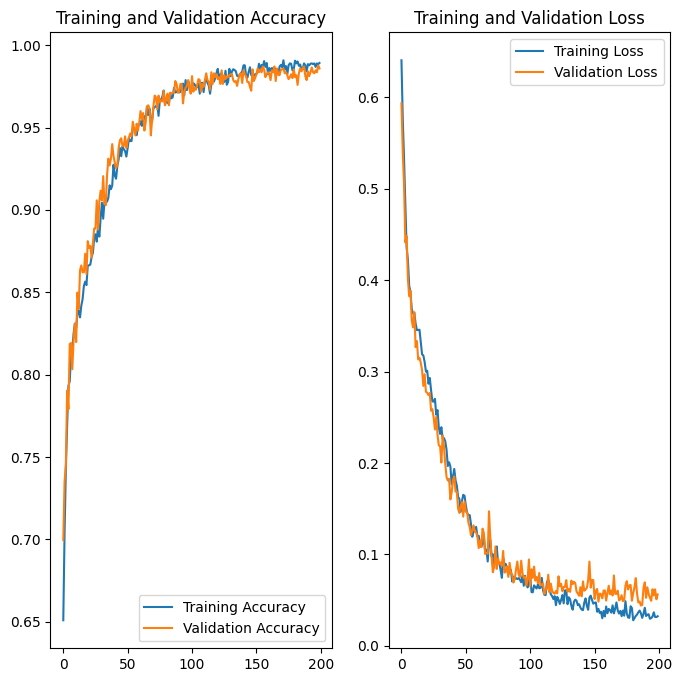

In [17]:


import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
model = load_model('models/best_model.pkl')
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

test_preds = (model.predict(X_test) > 0.5).astype("int32")

classification_report = metrics.classification_report(Y_test, test_preds)
print(classification_report)

80/80 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       978
         1.0       0.99      0.99      0.99      1568

    accuracy                           0.99      2546
   macro avg       0.99      0.99      0.99      2546
weighted avg       0.99      0.99      0.99      2546

